In [20]:
import re
import random
import enchant
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
from nltk.metrics import edit_distance
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# LOADING DATASETS

In [21]:
# a method that takes raw text and generates raw text out of it/ op parameter is used to either 
#to keep redundant elements or remove them
def tokenize_tweets(raw_tweets,op):

    tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
    tokens = tknzr.tokenize(raw_tweets)
    words = [w.lower() for w in tokens]
    if op == "vocab":
        vocab = set(words)
    elif op == "raw":
        vocab = words
    return vocab

In [22]:
# a method that reads a file and removes all non-ascii characters from it 
# returns raw_text,list [tweets]
def loadFile(filename):
       
    f = open(filename)
    raw_tweets = f.read()
    remove_nonunicode = re.sub(r'[^\x00-\x7F]',' ', raw_tweets)
    content = remove_nonunicode.splitlines()
    return remove_nonunicode,content

In [23]:
# method that returns 2 numpy arrays one having the tweets and another having labels (0 for positve/1 for negative)
# also returns a comined set of tokenized vocabullary and a combined raw text 
# having both raw tweets appended together
def loadData(pos_file,neg_file,op):
    
    #dataframe
    positive_raw,positive_tweets = loadFile(pos_file)
    negative_raw,negative_tweets = loadFile(neg_file)
    positive_labels = np.zeros((len(positive_tweets),),dtype=int)
    negative_labels = np.ones((len(negative_tweets),),dtype=int)
    combined_tweets = positive_tweets + negative_tweets
    combined_labels = np.append(positive_labels,negative_labels)
    # vocabullary 
    positive_vocab =  tokenize_tweets(positive_raw,op)
    negative_vocab =  tokenize_tweets(negative_raw,op)
    if op == "raw":
        combined_vocab =  positive_vocab + negative_vocab
    elif op == "vocab":
        combined_vocab =  list(positive_vocab.union(negative_vocab))
    # raw text
    combined_text = positive_raw + negative_raw
    return combined_tweets,combined_labels,combined_vocab,combined_text

In [26]:
positive_tweets_file = '../data/train_pos.txt'
negative_tweets_file = '../data/train_neg.txt'
combined_tweets,combined_labels,combined_vocab,combined_text = loadData(positive_tweets_file,negative_tweets_file,"vocab")
_,_,raw_vocab,_ = loadData(positive_tweets_file,negative_tweets_file,"raw")

# STEMMING WORDS

Word stemming is the process to find the stem of a word. To be more concrete as an example consider the following words eating,eats both are variations of the word eat. In our approach we know that tweets may include many repeated characters within one word, where people stress on their emotions. Thus we convert these words to words having only 2 repetions of these characters and we check if the reduced version is valid (found in dictionary)

In [27]:
# a method that finds a group of repeated letters and replaces them by 2 instances of that letter
def repl(matchObj):	
    char = matchObj.group(1)
    return "%s%s" % (char, char)

In [28]:
# checks if the word has repeated characters if true then we invoke the previous method
def replaceRepeatingCharacters(tweets):
    pattern = re.compile(r"(\w)\1+")
    corrected_words = pattern.sub(repl,tweets)
    return corrected_words

In [29]:
# check if current token is already correct(found in dictionary) 
#if not then call above function
# if word has changed => there os a sequence of repeating characters and hence we reccur
# otherwise the word is returned
def certifyToken(token):

    if wordnet.synsets(token): #if dictionary knows the token we return it
        return token
    reduced_token = replaceRepeatingCharacters(token) # remove repeating characters if any
    if reduced_token != token: # if the reduced word is different we may remove further
        return certifyToken(reduced_token)
    else:
        return reduced_token

# CORRECTING MISSPELLED WORDS

In this block, we focus on correcting misspelled words in tweets. This is achieved by using an english dictionary provided by enchant library, which checks if a word is correct or wrong.If wrong it provides us with suggestions for relevant replacement. We then compute the levensteihn distance between our token and the provided suggestion.
The first method constructs a python dictionary mapping every levensteihn distance to a count denoting number of suggestions that lie that far from the word. 
The second method replaces all wrong words by their respective suggestions based on a threshold we set.

In [30]:
# a method that returns the distribution of levensteihn distance between words and their corresponding suggestions
# distance 0 corresponds to a correct word
# distance -1 corresponds to a non alphabetic string
def findDistances(word_dict,tokens):

    distribution = dict({0:0,-1:0})
    for token in tokens:
        distance = 0
        if token.isalpha():
            if word_dict.check(token):
                distribution[0] = distribution[0] + 1
            else:
                suggestions = word_dict.suggest(token)
                if(len(suggestions)>0):
                    distance = edit_distance(token, suggestions[0])
                    if distance in distribution.keys():
                        distribution[distance] = distribution[distance] + 1
                    else:
                        distribution[distance] =  1
                        
                else:
                    distribution[-1] = distribution[-1] + 1
            
        else:
            distribution[-1] = distribution[-1] + 1
       
        
    return distribution 

In [31]:
# a method that checks wether the token is known by the dictionary provided by enchant library
# if yes returns it otherwise the dictionary provides a sey of suggestions 
# we compute levensthein distance to with the first suggestion if the distance is less than a certain threshold
# then we return the suggestion otherwise we keep the token as is
def correct_misspelled_word(word_dict,token,levenshtein_thresh):
    
    if word_dict.check(token):
        return token
    else:
        suggestions = word_dict.suggest(token)
        if(len(suggestions)>0):
            filtered_suggestions = list(filter(lambda x: x.isalpha(),suggestions))
            if (len(filtered_suggestions)>0):
                levenshtein_dist = edit_distance(token, filtered_suggestions[0])
                if levenshtein_dist<= levenshtein_thresh :
                         return filtered_suggestions[0]
                else:
                    return token
            else:
                levenshtein_dist = edit_distance(token, suggestions[0])
                if levenshtein_dist<= levenshtein_thresh :
                         return suggestions[0]
                else:
                    return token
                
        else:
            return token 

# CORRECTING AND STEMMING ALL TEXT

In [32]:
# this method is used to construct our vocabullary that we use to build our occurrence matrix
# it finds the stem of every token
def stemm_all_tokens(tokens):
    token_stemming = lambda token : certifyToken(token)
    correct_tweets = list(map(token_stemming,tokens))
    return correct_tweets

In [33]:
# this method is used to construct our vocabullary that we use to build our occurrence matrix
# it corrects every misspelled words
def correct_all_tokens(word_dict,tokens,levenshtein_thresh):
    token_stemming = lambda token : correct_misspelled_word(word_dict,token,levenshtein_thresh)
    correct_tweets = list(map(token_stemming,tokens))
    return correct_tweets

In [34]:
# this method uses a map to either stem or correct every token in a tweet
def correct_tweet(text,op,levenshtein_thresh):
    
    tokens = list(tokenize_tweets(text,"raw"))
    word_dict = enchant.Dict("en_US")
    if op == "spelling":
        correct_tokens = lambda token : correct_misspelled_word(word_dict,token,levenshtein_thresh)  if token.isalpha() else token
    elif op =="stemming":
        correct_tokens = lambda token : certifyToken(token)  if token.isalpha() else token
    corrected_tokens = list(map(correct_tokens,tokens))
    corrected_tweet = ' '.join(corrected_tokens)
    return corrected_tweet  

In [35]:
# this method takes a list of tweets and either corrects or stems the tweets by using a map function
def correct_all_tweets(tweets,op,levenshtein_thresh = 0):

    tweet_correction = lambda x : correct_tweet(x,op,levenshtein_thresh)
    correct_tweets = list(map(tweet_correction,tweets))
    return correct_tweets

# LOGISTIC REGRESSION

To compare our different methods of data cleaning we use the simplest model for classification which is the logistic one. 

In [46]:
# the method first constructs an occurrence matrix from a given set of vocabullary and tweets.
# then we use a 4 kfold splits to train our model and then check accuracy in prediction
def train_by_logistic(tweets,labels,vocab):
    
   
    cv = CountVectorizer(vocabulary=vocab)
    occurence = cv.fit_transform(tweets)
    kf = KFold(n_splits=4)
    scores = []
    kfold_index = 1
    for train_index, test_index in kf.split(occurence):
        X_train, X_test = occurence[train_index], occurence[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        logistic = LogisticRegression(C=1e5)
        model = logistic.fit(X_train,y_train)
        Y_pred = model.predict(X_test)
        accuracy = accuracy_score( y_test,Y_pred)
        scores.append((kfold_index,accuracy))
        kfold_index = kfold_index + 1
        
    return scores

# VISUALIZATION

We generate a couple of plots. The first is used to plot the levensteihn distance of suggested word replacements vs their frequency. The second method plots the accuracy of every kfold split of logistic regression

In [37]:
def plotDistribution(distribution,title,pngName):
    
    
    param = list(map(lambda x: x[0],distribution))
    frequency = list(map(lambda x: x[1],distribution))
    x_pos = np.arange(len(param)) 

    plt.figure(figsize=(20, 3))   
    plt.bar(x_pos,frequency,align='center')
    plt.xticks(x_pos,param) 
    plt.ylabel('Frequency')
    plt.title(title)
    plt.savefig(pngName)
    plt.show()

In [44]:
def plotAccuracy(x,y1,y2,xtitle,ytitle,graphTitle,pngName):
    
   
    plt.figure(figsize=(20, 3))
    plt.plot(x,y1,'r-',label='Correction without stemming')
    plt.plot(x,y2,'b-',label='Correction with stemming')
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.title(graphTitle)
    plt.legend()
    plt.savefig(pngName)
    plt.show()

# STATISTICS

In [39]:
def compute_levensteihn_distribution(vocab,title,pngName):
    
    word_dict = enchant.Dict("en_US")
    # find distributions
    distribution_raw =  findDistances(word_dict,vocab)
    
    raw =  sorted(list(distribution_raw.items()))

    plotDistribution(raw,title,pngName)

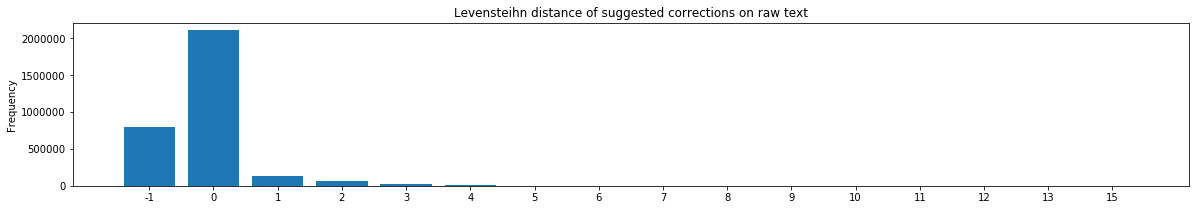

In [40]:
title = 'Levensteihn distance of suggested corrections on raw text'
compute_levensteihn_distribution(raw_vocab,title,'../plots/distributionA.png')

# OPTIMAL PERFORMANCE

In [41]:
def shuffle_data(x, y):
    
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    tempX = x
    tempY = y
    tempX=tempX[indices]
    tempY=tempY[indices]
    return tempX,tempY

In [43]:
def  find_optimum(combined_tweets,combined_labels,combined_vocab,thresh,pngName):
    
    
    word_dict = enchant.Dict("en_US")
    # correct tweets
    correct_tweets = correct_all_tweets(combined_tweets,"spelling",thresh)
    # correct tweet vocab
    correct_tweet_vocab = np.unique(correct_all_tokens(word_dict,combined_vocab,thresh))
    # stem words
    # correct stemmed words
    stemmed_words = stemm_all_tokens(combined_vocab)
    correct_stemmed_tokens =  np.unique(correct_all_tokens(word_dict,stemmed_words,thresh))
    # stemm tweets
    # correct stemmed tweets
    stemmed_tweets = correct_all_tweets(combined_tweets,"stemming",thresh)
    correct_stemmed_tweets = correct_all_tweets(stemmed_tweets,"spelling",thresh)
    
   
    correct_x,correct_y = shuffle_data( np.array(correct_tweets), combined_labels)
    stemmed_x,stemmed_y = shuffle_data( np.array(correct_stemmed_tweets), combined_labels)

    scores_correct = train_by_logistic(correct_x,correct_y,correct_tweet_vocab)
    scores_stemmed = train_by_logistic(stemmed_x,stemmed_y,correct_stemmed_tokens)
    
    
    
    kfolds = list(map(lambda x: x[0],scores_correct))
    correct_accuracy = list(map(lambda x: x[1],scores_correct))
    stemmed_accuracy = list(map(lambda x: x[1],scores_stemmed))
    title = 'Logistic regression accuracy on occurrency matrix before and after stemming dataset'
    plotAccuracy(kfolds,correct_accuracy,stemmed_accuracy,'kfold','accuracy',title,pngName)
    

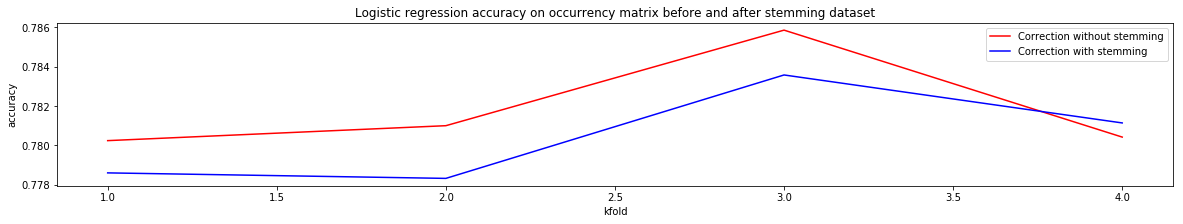

In [45]:
find_optimum(combined_tweets,combined_labels,combined_vocab,4,'../plots/raw.png')

# ELIMINATION OF REDUNDANT TWEETS

In [57]:
def eliminate_redundancy(tweets,vocab,thresh,pngName):
    unique_tweets = np.unique(tweets)
    find_optimum(unique_tweets,combined_labels,vocab,thresh,pngName)

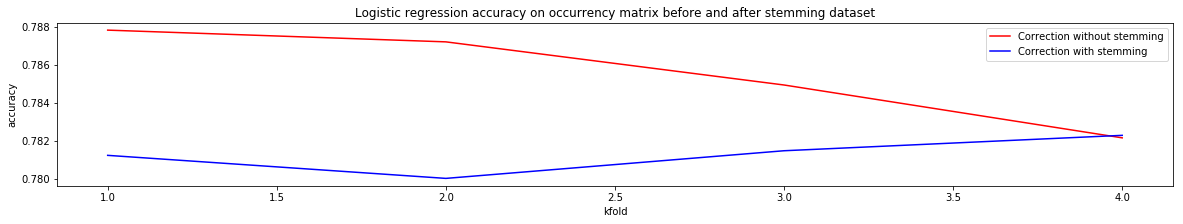

In [48]:
eliminate_redundancy(combined_tweets,combined_voca,5,'../plots/redundant.png')

# STRIP INITIAL CHARACTERS

In [49]:
def strip_token(token):
    
    contains_chars = re.search('[a-zA-Z]', token)
    if contains_chars is not None:
        regex = re.compile('[^a-zA-Z]')
        stripped = regex.sub('',token)
        return stripped
    else:
        return token
    

In [50]:
def correct_vocab(tokens):
    token_stemming = lambda token : strip_token(token)
    correct_tweets = list(map(token_stemming,tokens))
    return correct_tweets

In [51]:
def strip_tokens(text):
    
    tokens = list(tokenize_tweets(text,"raw"))
    correct_tokens = lambda token : strip_token(token)
    corrected_tokens = list(map(correct_tokens,tokens))
    corrected_tweet = ' '.join(corrected_tokens)
    return corrected_tweet
    

In [52]:
def strip_text(tweets):
    
    tweet_correction = lambda x :strip_tokens(x)
    correct_tweets = list(map(tweet_correction,tweets))
    return correct_tweets

In [53]:
filtered_tweets = strip_text(combined_tweets)
filtered_vocab = correct_vocab(combined_vocab)

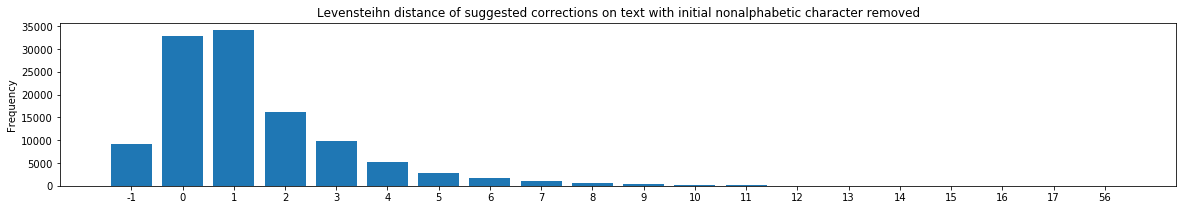

In [54]:
title = 'Levensteihn distance of suggested corrections on text with initial nonalphabetic character removed'
compute_levensteihn_distribution(filtered_vocab,title,'../plots/distributionB.png')

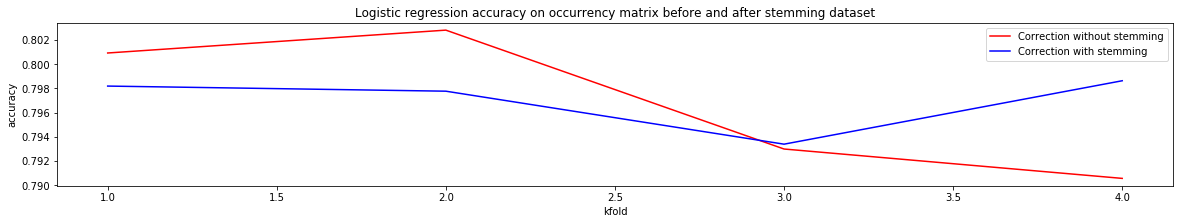

In [58]:
 eliminate_redundancy(filtered_tweets,filtered_vocab,5,'../plots/filtered_text.png')

# GENERATE CLEAN TWEETS

In [74]:
def generate(pos_file,neg_file):
    
    positive_raw,positive_tweets = loadFile(pos_file)
    negative_raw,negative_tweets = loadFile(neg_file)
    positive_vocab =  tokenize_tweets(positive_raw,"vocab")
    negative_vocab =  tokenize_tweets(negative_raw,"vocab")
    word_dict = enchant.Dict("en_US")
    
    filtered_tweets_pos = strip_text(positive_tweets)
    filtered_vocab_pos = correct_vocab(positive_vocab)
    filtered_tweets_neg = strip_text(negative_tweets)
    filtered_vocab_neg = correct_vocab(negative_vocab)
    
    unique_tweets_pos = np.unique(filtered_tweets_pos)
    unique_tweets_neg = np.unique(filtered_tweets_neg)
    
    correct_tweets_pos = correct_all_tweets(unique_tweets_pos ,"spelling",5)
    correct_tweet_vocab_pos = np.unique(correct_all_tokens(word_dict,filtered_vocab_pos,5))
    correct_tweets_neg = correct_all_tweets(unique_tweets_neg ,"spelling",5)
    correct_tweet_vocab_neg = np.unique(correct_all_tokens(word_dict,filtered_vocab_neg,5))
   
    writeToFile(correct_tweets_pos,'../tmp/clean_train_pos.txt')
    writeToFile(correct_tweet_vocab_pos,'../tmp/clean_train_vocab_pos.txt')
    writeToFile(correct_tweets_neg,'../tmp/clean_train_neg.txt')
    writeToFile(correct_tweet_vocab_neg,'../tmp/clean_train_vocab_neg.txt')
    

In [77]:
def writeToFile(data,outputSet):
    result = open(outputSet, 'w')
    if (type(data) is np.ndarray or type(data) is list):
        for item in data:
            result.write("%s\n" % item)
        result.close()

In [78]:
generate('../data/train_pos_full.txt','../data/train_neg_full.txt')